In [ ]:
!nvidia-smi

Mon Nov 23 10:36:49 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
%tensorflow_version 2.x
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
import tensorflow as tf
print(tf.__version__)

2.3.0


In [ ]:
# https://github.com/42io/dataset/tree/master/google_speech_commands
DATASET_FILE = '1NgIw6JrdjDcRhnAxbheqtAcV5Fr-wUJu' # 0-9up.npz

In [ ]:
!test -f "$DATASET_FILE" || gdown --id "$DATASET_FILE" -O "$DATASET_FILE"

Downloading...
From: https://drive.google.com/uc?id=1NgIw6JrdjDcRhnAxbheqtAcV5Fr-wUJu
To: /content/1NgIw6JrdjDcRhnAxbheqtAcV5Fr-wUJu
2.59GB [00:28, 90.2MB/s]


In [ ]:
md5 = !md5sum "$DATASET_FILE"
assert '54821a74684e7bbb9b3acd853960d9cd' == md5[0].split()[0]

In [ ]:
dset = np.load(DATASET_FILE)
print(dset['x_train'].shape)

(1095480, 637)


In [ ]:
x_train, x_test, x_valid = (
    dset[i].reshape(-1, 49, 13)[:,1:-1]
    for i in ['x_train', 'x_test', 'x_valid']
)
y_train = dset['y_train']
y_test  = dset['y_test']
y_valid = dset['y_valid']

In [ ]:
def spectrogram_masking(spectrogram, dim=1, masks_number=2, mask_max_size=5):
  """Spectrogram masking on frequency or time dimension.
  Args:
    spectrogram: Input spectrum [batch, time, frequency]
    dim: dimension on which masking will be applied: 1 - time; 2 - frequency
    masks_number: number of masks
    mask_max_size: mask max size
  Returns:
    masked spectrogram
  """
  if dim not in (1, 2):
    raise ValueError('Wrong dim value: %d' % dim)
  input_shape = spectrogram.shape
  time_size, frequency_size = input_shape[1:3]
  dim_size = input_shape[dim]  # size of dimension on which mask is applied
  stripe_shape = [1, time_size, frequency_size]
  for _ in range(masks_number):
    mask_end = tf.random.uniform([], 0, mask_max_size, tf.int32)
    mask_start = tf.random.uniform([], 0, dim_size - mask_end, tf.int32)

    # initialize stripes with stripe_shape
    stripe_ones_left = list(stripe_shape)
    stripe_zeros_center = list(stripe_shape)
    stripe_ones_right = list(stripe_shape)

    # update stripes dim
    stripe_ones_left[dim] = dim_size - mask_start - mask_end
    stripe_zeros_center[dim] = mask_end
    stripe_ones_right[dim] = mask_start

    # generate mask
    mask = tf.concat((
        tf.ones(stripe_ones_left, spectrogram.dtype),
        tf.zeros(stripe_zeros_center, spectrogram.dtype),
        tf.ones(stripe_ones_right, spectrogram.dtype),
    ), dim)
    spectrogram = spectrogram * mask
  return spectrogram

In [ ]:
plt.rc('figure', figsize=(13, 4))

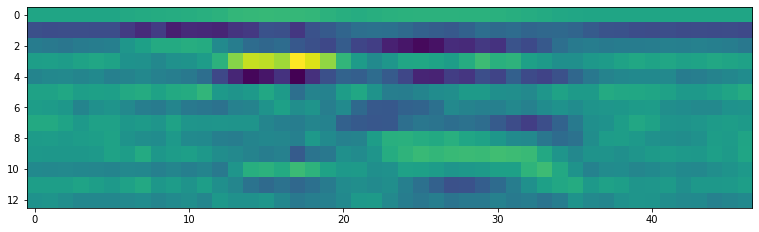

In [ ]:
plt.imshow(x_train[0].T)

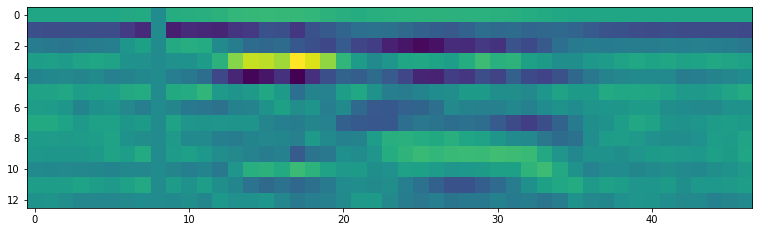

In [ ]:
plt.imshow(spectrogram_masking(x_train[0:1], 1, 3, 3).numpy()[0].T)

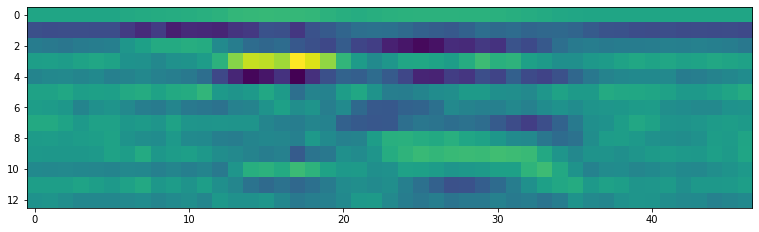

In [ ]:
plt.imshow(spectrogram_masking(x_train[0:1], 2, 2, 2).numpy()[0].T)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(len(x_train))
train_dataset = train_dataset.batch(128)
train_dataset = train_dataset.map(lambda x, y: (spectrogram_masking(x, 1, 3, 3), y))
train_dataset = train_dataset.map(lambda x, y: (spectrogram_masking(x, 2, 2, 2), y))

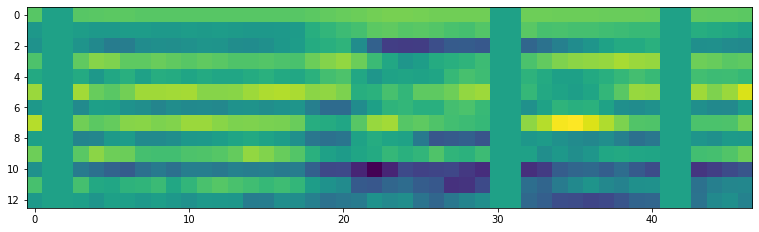

In [ ]:
plt.imshow(list(train_dataset.take(1))[0][0][0].numpy().T)

In [ ]:
# https://arxiv.org/pdf/2005.06720.pdf

def streaming_input_output(streaming, t, inputs, otputs, x):
  if streaming:
    otputs.append(x)
    x = keras.Input(shape=[t] + x.shape[2:])
    inputs.append(x)
  return x

def build_model(streaming=False):

  # resetting the layer name generation counter
  keras.backend.clear_session()

  inputs  = []
  outputs = []

  x = x_in = keras.Input(shape=(1 if streaming else 47, 13))

  x = keras.layers.Conv1D(128, 1, use_bias=False)(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.ReLU()(x)
  x = keras.layers.SpatialDropout1D(0.1)(x)

  for i in range(4):
    x = streaming_input_output(streaming, 1 + 2**i, inputs, outputs, x)
    x = keras.layers.SeparableConv1D(128, 2, dilation_rate=2**i, use_bias=False)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)
    x = keras.layers.SpatialDropout1D(0.1)(x)

  x = streaming_input_output(streaming, 32, inputs, outputs, x)
  x = keras.layers.AveragePooling1D(x.shape[1])(x)
  x = keras.layers.Flatten()(x)

  x = keras.layers.Dense(128, use_bias=False)(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.ReLU()(x)
  x = keras.layers.Dropout(0.1)(x)

  x = keras.layers.Dense(12)(x)
  x = keras.layers.Softmax()(x)

  model = keras.Model(inputs=[x_in] + inputs, outputs=[x] + outputs)

  model.summary()

  return model

In [ ]:
model = build_model()

model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 47, 13)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 47, 128)           1664      
_________________________________________________________________
batch_normalization (BatchNo (None, 47, 128)           512       
_________________________________________________________________
re_lu (ReLU)                 (None, 47, 128)           0         
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 47, 128)           0         
_________________________________________________________________
separable_conv1d (SeparableC (None, 46, 128)           16640     
_________________________________________________________________
batch_normalization_1 (Batch (None, 46, 128)          

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        mode='min',
        verbose=1,
        patience=100,
        restore_best_weights=True)

history = model.fit(train_dataset,
                    validation_data=(x_valid, y_valid),
                    callbacks=[early_stopping],
                    verbose=2,
                    epochs=100500)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


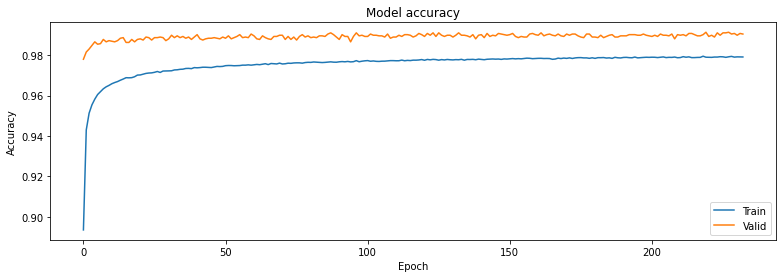

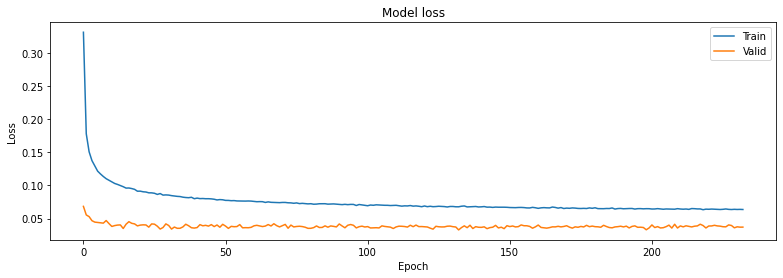

In [ ]:
print(history.history.keys())

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='lower right')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper right')
plt.show()

In [ ]:
results = model.evaluate(x_train, y_train, verbose=0)
print('train loss, train acc:', results)

results = model.evaluate(x_test, y_test, verbose=0)
print('test loss, test acc:', results)

results = model.evaluate(x_valid, y_valid, verbose=0)
print('valid loss, valid acc:', results)

train loss, train acc: [0.009594948962330818, 0.9970177412033081]
test loss, test acc: [0.05499657616019249, 0.9862178564071655]
valid loss, valid acc: [0.03273259475827217, 0.9910926222801208]


In [ ]:
assert(len(x_test) + len(x_valid) == 7141)
pred = model.predict(x_test).argmax(axis=-1)
print(np.sum(pred != y_test), len(pred))
pred = model.predict(x_valid).argmax(axis=-1)
print(np.sum(pred != y_valid), len(pred))

52 3773
30 3368


In [ ]:
stream_model = build_model(True)

# copy weights from old model to new one
for layer in stream_model.layers:
    if layer.get_weights():
      print("Transfer weights for layer {}".format(layer.name))
      layer.set_weights(model.get_layer(name=layer.name).get_weights())

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 32, 128)]    0                                            
__________________________________________________________________________________________________
average_pooling1d (AveragePooli (None, 1, 128)       0           input_6[0][0]                    
__________________________________________________________________________________________________
flatten (Flatten)               (None, 128)          0           average_pooling1d[0][0]          
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          16384       flatten[0][0]                    
_______________________________________________________________________________________

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(stream_model)
converter.experimental_new_converter = False
tflite_model = converter.convert()
with open("dcnn.tflite", "wb") as f:
  f.write(tflite_model)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmpwfecze9f/assets


In [ ]:
interpreter = tf.lite.Interpreter(model_path="dcnn.tflite")
interpreter.allocate_tensors()

for i in ['name']:
  indeces = [d[i] for d in interpreter.get_output_details()]
  assert indeces == sorted(indeces)
  indeces = [d[i] for d in interpreter.get_input_details()]
  assert indeces == sorted(indeces)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
!md5sum 'dcnn.tflite'
!mv 'dcnn.tflite' '/content/gdrive/My Drive/0-9.dscnn13.streaming.tflite'

391123c5d62c1a30f3259e2a35093dc6  dcnn.tflite
